In [1]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,upper,udf,element_at,explode,regexp_replace,size
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DateType

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

import os

spark = SparkSession \
    .builder \
    .appName("FHIR Analytics with Python") \
    .getOrCreate()
keyspace = "myCatalog.hfs_data"


In [2]:
spark.conf.set("spark.sql.catalog.myCatalog", "com.datastax.spark.connector.datasource.CassandraCatalog")

In [3]:
def getMaritalStatus(ms):
    return ms.text_
gms = udf(getMaritalStatus, StringType())
def getBirthDate(bd):
    return bd[0]
gbd = udf(getBirthDate, DateType())

def getAvgForLoinc(loinc_code, agg_column, df):
    return df.filter(col("LoincCode").like(loinc_code)) \
                         .withColumnRenamed("ValueQuantity", agg_column) \
                         .select(col("Subject"), col(agg_column)) \
                         .groupBy("Subject").agg(F.round(F.avg(col(agg_column)), 3).alias(agg_column))

In [4]:
rawPatient = spark.read.table(keyspace + ".patient")
rawReference = spark.read.table(keyspace + ".reference")
#rawReference = spark.read.format("org.apache.spark.sql.cassandra").options(**{"table": "reference","keyspace": "hfs_data"}).load()
#rawObservation = spark.read.format("org.apache.spark.sql.cassandra").options(**{"table": "observation","keyspace": "hfs_data"}).load()
rawObservation = spark.read.table(keyspace + ".observation")
rawEncounter = spark.read.table(keyspace + ".encounter")

In [5]:
patientDataFrame = rawPatient.select(col("id").alias("PatientId"), gms(col("maritalstatus")).alias("Marital Status"), col("birthdate")["0"].alias("birthdate"), upper(col("gender")).alias("Gender")).withColumn("Age", F.round(F.datediff(F.current_date(), F.to_date(col("birthdate"))) / 365, 1))
#patientDataFrame = patientDataFrame.withColumn("gender", upper(col("gender")))
#patientDataFrame = patientDataFrame.withColumnRenamed("maritalstatus_trunc", "maritalstatus")

In [6]:
# select only Patient references and manipulate the column values so they are ready for joining with other tables

referenceDataFrame = rawReference.where(rawReference.reference.like("Patient%")).select(regexp_replace(rawReference.id, "#hidden", "").alias("id"), regexp_replace(rawReference.reference, "Patient/", "").alias("reference"))

In [7]:
referenceDataFrame.count()

5336778

In [8]:
referenceDataFrame.cache()

DataFrame[id: string, reference: string]

In [9]:
# rename some observation columns AND join with reference table to resolve Patient ID references properly

observationDataFrame = rawObservation.select(col("id").alias("ObservationId"), col("code"), col("component"), col("valuequantity"), col("subject").alias("PatientReferenceId"))
observationDataFrame = referenceDataFrame.join(observationDataFrame, referenceDataFrame.id == observationDataFrame.PatientReferenceId) \
                  .withColumn("id", col("id").cast(StringType())).withColumn("reference", col("reference").cast(StringType())) \
                  .withColumnRenamed('reference', "PatientId") \
                  .drop(col("id")) \
                  .drop(col("PatientReferenceId"))




In [10]:
# Filter and select LOINC information from observation dataframe

observationDataFrame_loinc = observationDataFrame \
    .select(col("PatientId").alias("Subject"), \
            col("ObservationId"), \
            col("code").coding[0].code.alias("LoincCode"), \
            col("valuequantity").value.alias("ValueQuantity"))

loinc_code_list = ["8480-6", "8462-4","29463-7","8302-2","33914-3","2571-8","2085-9","18262-6","2093-3","39156-5","55284-4", "195967001", "233678006"]


observationDataFrame_loinc = observationDataFrame_loinc \
    .filter(col("LoincCode").isin(loinc_code_list))\
    .na.drop()

In [11]:
observationDataFrame.count()

2198746

In [12]:
observationDataFrame_loinc.cache()

DataFrame[Subject: string, ObservationId: string, LoincCode: string, ValueQuantity: decimal(38,18)]

In [13]:
# Select only Body Weight observations from pre-filtered observation data frame

body_weight_df = observationDataFrame_loinc \
    .filter(col("LoincCode").like("%29463-7%")) \
    .withColumnRenamed("ValueQuantity", "Body Weight") \
    .select(col("Subject"), col("Body Weight")) \
    .na.drop() \
    .dropDuplicates()

In [14]:
# Calculate Systolic, Dystolic and total BP, then avg per patient

blood_pressure_df = observationDataFrame.select(col("PatientId").alias("Subject"),
                          "ObservationId",
                          col("component")[0].code.coding[0].code.alias("DBPCode"), \
                          col("component")[0].valuequantity.value.alias("Diastolic Blood Pressure"), \
                          col("component")[1].code.coding[0].code.alias("SBPCode"), \
                          col("component")[1].valuequantity.value.alias("Systolic Blood Pressure")).na.drop()



blood_pressure_df = blood_pressure_df.withColumn("Blood Pressure", \
      F.round(col("Diastolic Blood Pressure")+(col("Systolic Blood Pressure") - col("Diastolic Blood Pressure"))/3))

blood_pressure_avg_df = blood_pressure_df.groupBy(col("Subject")).agg(F.round(F.avg("Diastolic Blood Pressure"), 3).alias("Diastolic BP"), \
                                           F.round(F.avg("Systolic Blood Pressure"), 3).alias("Systolic BP"), \
                                           F.round(F.avg("Blood Pressure"), 3).alias("BP") \
                                          )


In [15]:
# Select all encounters that show as Asthma diagnoses

encounterDataFrame = rawEncounter.filter(F.size(col("reasoncode")) > 0).select(col("subject"), col("reasoncode")[0].coding[0]["code"].alias("Asthma")) \
                                 .withColumn("Asthma", F.when(col("Asthma").isin(["195967001","233678006"]), F.lit(1)).otherwise(F.lit(0)))

encounterDataFrame = encounterDataFrame.join(referenceDataFrame, encounterDataFrame.subject == referenceDataFrame.id) \
                                               .drop("subject", "id") \
                                               .withColumnRenamed("reference", "subject")

encounterDataFrame_asthma = encounterDataFrame.groupBy("subject").agg(F.max(col("Asthma")).alias("Asthma"))

In [16]:
# Calculate avg body weight per patient and join with patient data frame

patient_calc_df = body_weight_df.groupBy("Subject").agg(F.round(F.avg("Body Weight"), 3).alias("Body Weight")) \
                                .join(patientDataFrame, body_weight_df.Subject == patientDataFrame.PatientId) \
                                .drop("Subject")

# Add literal demo info to patients
patient_calc_df = patient_calc_df.dropDuplicates() \
                                 .withColumn("Disease", F.array(F.lit("0"))) \
                                 .withColumn("PostalCode", F.array(F.lit("0")))

# Join BP info by patient
# COMMENTED OUT BECAUSE LASSO
patient_calc_df = blood_pressure_avg_df.join(patient_calc_df, \
                                             blood_pressure_avg_df.Subject == patient_calc_df.PatientId) \
                                       .drop("Subject")

# Join asthma info by patient
patient_calc_df = encounterDataFrame_asthma.join(patient_calc_df, encounterDataFrame_asthma.subject == patient_calc_df.PatientId) \
                   .dropDuplicates() \
                   .drop(col("subject"))

# Calculate and join avg triglycerides by patient
triglycerides_df = getAvgForLoinc("%2571-8%", "Triglycerides", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(triglycerides_df, patient_calc_df.PatientId == triglycerides_df.Subject) \
                                 .drop(col("Subject"))

# Calculate and join average EGFR by patient
egfrLoincCode = ["88294-4", "33914-3"]
agg_column = "Estimated Glomerular Filtration Rate"

egfr_df = observationDataFrame_loinc.select(col("Subject"), col("LoincCode"), col("ValueQuantity")) \
                                 .filter(col("LoincCode").isin(egfrLoincCode)) \
                                 .withColumn(agg_column, col("ValueQuantity")) \
                                 .groupBy("Subject").agg(F.round(F.avg(col(agg_column))).alias(agg_column))

# COMMENTED OUT BECAUSE LASSO
patient_calc_df = patient_calc_df.join(egfr_df, patient_calc_df.PatientId == egfr_df.Subject) \
                                 .drop(col("Subject"))

# COMMENTED OUT BECAUSE LASSO
# Calculate and join avg LDL by patient
ldl_df = getAvgForLoinc("%18262-6%", "Low Density Lipoprotein", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(ldl_df, patient_calc_df.PatientId == ldl_df.Subject) \
                   .dropDuplicates().drop(col("Subject"))

# Calculate and join average HDL by patient
hdl_df = getAvgForLoinc("%2085-9%", "High Density Lipoprotein Cholesterol", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(hdl_df, patient_calc_df.PatientId == hdl_df.Subject) \
                   .drop(col("Subject"))

# Calculate and join average height by patient
height_df = getAvgForLoinc("%8302-2%", "Body Height", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(height_df, patient_calc_df.PatientId == height_df.Subject) \
                   .drop(col("Subject"))

#Calculate and join average BMI by patient
bmi_df = getAvgForLoinc("%39156-5%", "BMI", observationDataFrame_loinc)
    
patient_calc_df = patient_calc_df.join(bmi_df, patient_calc_df.PatientId == bmi_df.Subject) \
                   .drop(col("Subject"))

#Calculate and join average cholesterol by patient
cholesterol_df = getAvgForLoinc("%2093-3%", "Total Cholesterol", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(cholesterol_df, patient_calc_df.PatientId == cholesterol_df.Subject) \
                   .drop(col("Subject"))


In [17]:
asthma_dataset = patient_calc_df.drop("PatientId", "Disease", "PostalCode", "birthdate", "Diagnosed Date").na.drop()

In [18]:
asthma_dataset.schema.names

['Asthma',
 'Diastolic BP',
 'Systolic BP',
 'BP',
 'Body Weight',
 'Marital Status',
 'Gender',
 'Age',
 'Triglycerides',
 'Estimated Glomerular Filtration Rate',
 'Low Density Lipoprotein',
 'High Density Lipoprotein Cholesterol',
 'Body Height',
 'BMI',
 'Total Cholesterol']

In [19]:
asthma_dataset.cache()

DataFrame[Asthma: int, Diastolic BP: decimal(38,3), Systolic BP: decimal(38,3), BP: decimal(38,3), Body Weight: decimal(38,3), Marital Status: string, Gender: string, Age: double, Triglycerides: decimal(38,3), Estimated Glomerular Filtration Rate: decimal(38,0), Low Density Lipoprotein: decimal(38,3), High Density Lipoprotein Cholesterol: decimal(38,3), Body Height: decimal(38,3), BMI: decimal(38,3), Total Cholesterol: decimal(38,3)]

In [20]:
asthma_dataset.show()

+------+------------+-----------+-------+-----------+--------------+------+-----+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+
|Asthma|Diastolic BP|Systolic BP|     BP|Body Weight|Marital Status|Gender|  Age|Triglycerides|Estimated Glomerular Filtration Rate|Low Density Lipoprotein|High Density Lipoprotein Cholesterol|Body Height|   BMI|Total Cholesterol|
+------+------------+-----------+-------+-----------+--------------+------+-----+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+
|     0|      80.909|    117.182| 93.091|     99.586|             M|  MALE| 80.6|      152.346|                                  56|                112.295|                              58.404|    176.700|32.199|          181.052|
|     0|      79.303|    122.929| 93.838|     99.777|             S|  MALE|1

In [21]:
asthma_dataset.count()

1932

In [22]:
asthma_dataset.filter(col("Asthma") == 1).count()

88

In [120]:
trainDF, testDF = asthma_dataset.randomSplit([.8, .2], seed = 42)
print(f"""There are {trainDF.count()} rows in the training set and {testDF.count()} in the test set""")

There are 1529 rows in the training set and 403 in the test set


In [121]:
num_asthma = trainDF.groupBy("Asthma").count().select("count").filter(col("Asthma") == 1).first()[0]
ratio = num_asthma/trainDF.count()

trainDF = trainDF.withColumn("weights", F.when(trainDF.Asthma == 1, 1-ratio).otherwise(ratio))
trainDF.select("Asthma", "weights").show()

+------+--------------------+
|Asthma|             weights|
+------+--------------------+
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     1|  0.9496402877697842|
|     1|  0.9496402877697842|
|     1|  0.9496402877697842|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
|     0|0.050359712230215826|
+------+--------------------+
only showing top 20 rows



In [45]:
categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols = categoricalCols, outputCols = indexOutputCols, handleInvalid = "skip")
oheEncoder = OneHotEncoder(inputCols = indexOutputCols, outputCols = oheOutputCols)

numericCols = [field for (field, dataType) in trainDF.dtypes
                if dataType != "string" and field != "Asthma"]

assemblerInputs = oheOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")

In [93]:
# Train a model one time, see a baseline using Generalized Linear Regression

from pyspark.ml.regression import GeneralizedLinearRegression

glm = GeneralizedLinearRegression(family = "binomial", labelCol = "Asthma")
glm_pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, glm])

glm_model = glm_pipeline.fit(trainDF)
predDF = glm_model.transform(testDF)

summary = glm_model.stages[-1].summary
# print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
# print("T Values: " + str(summary.tValues))
# print("P Values: " + str(summary.pValues))
# print("Dispersion: " + str(summary.dispersion))
# print("Null Deviance: " + str(summary.nullDeviance))
# print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
# print("Deviance: " + str(summary.deviance))
# print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
# print("AIC: " + str(summary.aic))
# print("Deviance Residuals: ")
# summary.residuals().show()
print(summary)
predDF.select("features", "Asthma", "prediction", "Gender").filter(col("Asthma") == 0).show()

Coefficients:
             Feature Estimate   Std Error T Value P Value
         (Intercept) -13.2290 175066.8659 -0.0001  0.9999
 Marital StatusOHE_M  24.4880 175066.8653  0.0001  0.9999
 Marital StatusOHE_S  24.3249 175066.8653  0.0001  0.9999
      GenderOHE_MALE   0.1045      0.3411  0.3064  0.7593
        Diastolic BP  -0.2342      1.1437 -0.2048  0.8378
         Systolic BP  -0.0718      0.5693 -0.1262  0.8996
                  BP   0.2955      1.7105  0.1727  0.8629
         Body Weight   0.0933      0.0889  1.0491  0.2941
                 Age  -0.0199      0.0071 -2.8120  0.0049
       Triglycerides  -0.0078      0.0085 -0.9181  0.3585
Estimated Glomeru...  -0.0058      0.0037 -1.5669  0.1171
Low Density Lipop...   0.0128      0.0207  0.6209  0.5346
High Density Lipo...   0.0119      0.0376  0.3179  0.7506
         Body Height  -0.1001      0.0890 -1.1245  0.2608
                 BMI  -0.2063      0.2578 -0.8001  0.4236
   Total Cholesterol   0.0071      0.0177  0.4008  0.6885


In [94]:
# Use CrossValidator to select the best model from 2 possible regParams

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

paramGrid = ParamGridBuilder() \
    .addGrid(glm.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=glm_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol = "Asthma"),
                          numFolds=2
                         )  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainDF)
prediction = cvModel.transform(testDF)
selected = prediction.select("Asthma", "prediction").show()

+------+--------------------+
|Asthma|          prediction|
+------+--------------------+
|     0|0.029783300772994462|
|     0| 0.04699046728480411|
|     0| 0.10640218517911243|
|     0| 0.06605361343942258|
|     0|0.041614159534607585|
|     0| 0.03496235263435109|
|     0|0.028905544897366776|
|     0|0.026822150745861407|
|     1| 0.03620146670867375|
|     0| 0.07423212150558435|
|     0|0.060717591007468125|
|     0| 0.10235409508014114|
|     0|  0.0695907155255222|
|     0| 0.04301988547916102|
|     0|0.055806023761486946|
|     0|0.055942429292341965|
|     0|0.032881672515543185|
|     0|0.024016142561926974|
|     0| 0.04000731775756364|
|     0| 0.08124987666064394|
+------+--------------------+
only showing top 20 rows



In [97]:
# Print the summary (need help interpreting this)

trainingSummary = cvModel.bestModel.stages[-1].summary

print(trainingSummary)

Coefficients:
             Feature Estimate Std Error T Value P Value
         (Intercept)   5.7314   12.7231  0.4505  0.6524
 Marital StatusOHE_M   0.0897    0.2915  0.3075  0.7584
 Marital StatusOHE_S  -0.0373    0.2927 -0.1273  0.8987
      GenderOHE_MALE   0.0486    0.2506  0.1937  0.8464
        Diastolic BP  -0.0345    0.1994 -0.1728  0.8628
         Systolic BP   0.0263    0.1026  0.2567  0.7974
                  BP  -0.0018    0.2944 -0.0063  0.9950
         Body Weight   0.0635    0.0714  0.8895  0.3737
                 Age  -0.0193    0.0070 -2.7507  0.0059
       Triglycerides  -0.0075    0.0085 -0.8893  0.3738
Estimated Glomeru...  -0.0058    0.0037 -1.5672  0.1171
Low Density Lipop...   0.0126    0.0206  0.6126  0.5401
High Density Lipo...   0.0130    0.0374  0.3473  0.7284
         Body Height  -0.0684    0.0716 -0.9552  0.3395
                 BMI  -0.1197    0.2052 -0.5831  0.5598
   Total Cholesterol   0.0068    0.0177  0.3822  0.7023

(Dispersion parameter for binomia

In [122]:
# Try a "default" Logistic Regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = "Asthma", featuresCol = "features", maxIter=10, weightCol = "weights")
lr.setThreshold(bestThreshold)
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

# Fit the model
lrModel = pipeline.fit(trainDF)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.stages[-1].coefficients))
print("Intercept: " + str(lrModel.stages[-1].intercept))

print(lrModel.stages[-1].summary)


predDF = lrModel.transform(testDF)

predDF.select("features", "Asthma", "prediction").show()

Coefficients: [0.073896295438675,-0.057422534518305784,0.011285497491574138,-0.0014736999879823897,0.002647984985692054,0.0007746682168225125,0.0035683485073375034,-0.020264845026867154,-0.004614199175387661,-0.00672409518201063,0.003385291050491452,0.0017065268726461154,-0.007049002913473207,0.03312108946544834,0.007591461447243598]
Intercept: -0.0018476508199910912
+--------------------+------+----------+
|            features|Asthma|prediction|
+--------------------+------+----------+
|[0.0,1.0,1.0,79.3...|     0|       1.0|
|[1.0,0.0,0.0,83.0...|     0|       1.0|
|[1.0,0.0,1.0,107....|     0|       1.0|
|[0.0,1.0,1.0,72.4...|     0|       1.0|
|[1.0,0.0,0.0,80.4...|     0|       1.0|
|[1.0,0.0,0.0,81.0...|     0|       1.0|
|[1.0,0.0,1.0,75.5...|     0|       1.0|
|[0.0,1.0,0.0,81.1...|     0|       1.0|
|[1.0,0.0,0.0,80.0...|     1|       1.0|
|[0.0,1.0,0.0,82.1...|     0|       1.0|
|[0.0,1.0,0.0,102....|     0|       1.0|
|[0.0,1.0,1.0,74.1...|     0|       1.0|
|[1.0,0.0,1.0,7

In [63]:
### DON'T REALLY KNOW WHAT THIS DOES - it seems like 'lr.setThreshold' is supposed to improve the prediction ability

# # Extract the summary from the returned LogisticRegressionModel instance trained
# # in the earlier example
# trainingSummary = lrModel.stages[-1].summary

# # Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# # Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
# trainingSummary.roc.show()
# print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# # Set the model threshold to maximize F-Measure
# fMeasure = trainingSummary.fMeasureByThreshold
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# print(bestThreshold)
# lr.setThreshold(bestThreshold)

objectiveHistory:
0.19957303511063312
+---+---+
|FPR|TPR|
+---+---+
|0.0|0.0|
|1.0|1.0|
|1.0|1.0|
+---+---+

areaUnderROC: 0.5
0.050359712230215826


LogisticRegression_51da4cc72fda

In [123]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol = "Asthma"),
                          numFolds=2
                         )  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainDF)
prediction = cvModel.transform(testDF)
selected = prediction.select("Asthma", "prediction").where(col("Asthma") == 1).show()

+------+----------+
|Asthma|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+



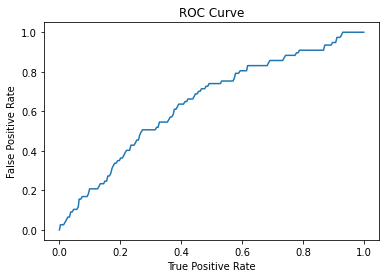

Training set areaUnderROC for untuned model: 0.6438857285964724


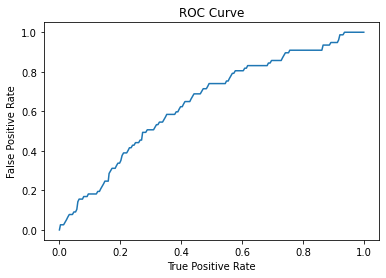

Training set areaUnderROC for BEST model: 0.643232800257594


In [124]:
roc = lrModel.stages[-1].summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC for untuned model: ' + str(lrModel.stages[-1].summary.areaUnderROC))

roc = cvModel.bestModel.stages[-1].summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC for BEST model: ' + str(cvModel.bestModel.stages[-1].summary.areaUnderROC))

In [125]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = "Asthma", featuresCol = "features", maxIter=10, elasticNetParam = 1, weightCol = "weights")
lr.setThreshold(bestThreshold)
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

# Fit the model
lrModel = pipeline.fit(trainDF)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.stages[-1].coefficients))
print("Intercept: " + str(lrModel.stages[-1].intercept))

print(str(lrModel.stages[-1].summary))

predDF = lrModel.transform(testDF)

predDF.select("features", "Asthma", "prediction").show()

Coefficients: [0.0738962954386773,-0.05742253451830661,0.011285497491578611,-0.0014736999879825796,0.0026479849856921524,0.0007746682168224614,0.003568348507337677,-0.02026484502686723,-0.004614199175387837,-0.006724095182010805,0.0033852910504915926,0.0017065268726460115,-0.00704900291347307,0.03312108946544751,0.007591461447243688]
Intercept: -0.00184765081999114
+--------------------+------+----------+
|            features|Asthma|prediction|
+--------------------+------+----------+
|[0.0,1.0,1.0,79.3...|     0|       1.0|
|[1.0,0.0,0.0,83.0...|     0|       1.0|
|[1.0,0.0,1.0,107....|     0|       1.0|
|[0.0,1.0,1.0,72.4...|     0|       1.0|
|[1.0,0.0,0.0,80.4...|     0|       1.0|
|[1.0,0.0,0.0,81.0...|     0|       1.0|
|[1.0,0.0,1.0,75.5...|     0|       1.0|
|[0.0,1.0,0.0,81.1...|     0|       1.0|
|[1.0,0.0,0.0,80.0...|     1|       1.0|
|[0.0,1.0,0.0,82.1...|     0|       1.0|
|[0.0,1.0,0.0,102....|     0|       1.0|
|[0.0,1.0,1.0,74.1...|     0|       1.0|
|[1.0,0.0,1.0,78.

In [90]:
### DON'T REALLY KNOW WHAT THIS DOES - it seems like 'lr.setThreshold' is supposed to improve the prediction ability

# # Extract the summary from the returned LogisticRegressionModel instance trained
# # in the earlier example
# trainingSummary = lrModel.stages[-1].summary

# # Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# # Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
# trainingSummary.roc.show()
# print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# # Set the model threshold to maximize F-Measure
# fMeasure = trainingSummary.fMeasureByThreshold
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# print(bestThreshold)
# lr.setThreshold(bestThreshold)

objectiveHistory:
0.19957303511063318
0.1980360786879265
0.19578566738076192
0.19466842298268786
0.19461072037354482
0.19459174145089056
0.19453652813550298
0.1944161920721103
0.19415990153974613
0.19379948169880457
0.19341199995275676
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.003443526170798898|0.025974025974025976|
|0.008953168044077135|0.025974025974025976|
|0.013774104683195593|0.025974025974025976|
| 0.01859504132231405| 0.03896103896103896|
|0.022727272727272728| 0.06493506493506493|
|0.026859504132231406| 0.07792207792207792|
| 0.03168044077134986| 0.09090909090909091|
|  0.0371900826446281| 0.09090909090909091|
| 0.04201101928374656| 0.09090909090909091|
|0.046831955922865015|  0.1038961038961039|
| 0.05165289256198347| 0.11688311688311688|
| 0.05647382920110193| 0.11688311688311688|
| 0.06129476584022039| 0.12987012987012986|
| 0.065426997245

LogisticRegression_9c1ea554150c

In [128]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.05, .3]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol = "Asthma"),
                          numFolds=2
                         )  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainDF)
prediction = cvModel.transform(testDF)
selected = prediction.select("Asthma", "prediction").where(col("Asthma") == 1).show()

+------+----------+
|Asthma|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+



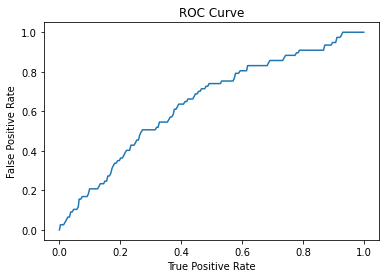

Training set areaUnderROC for untuned model: 0.6438857285964724


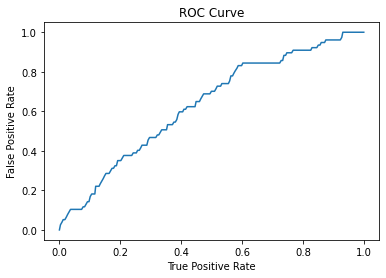

Training set areaUnderROC for BEST model: 0.6333583771600304


In [129]:
roc = lrModel.stages[-1].summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC for untuned model: ' + str(lrModel.stages[-1].summary.areaUnderROC))

roc = cvModel.bestModel.stages[-1].summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC for BEST model: ' + str(cvModel.bestModel.stages[-1].summary.areaUnderROC))